In [15]:
# from google.colab import drive

# drive.mount('/content/drive', force_remount=True)

# # 输入daseCV所在的路径
# # 'daseCV' 文件夹包括 '.py', 'classifiers' 和'datasets'文件夹
# # 例如 'CV/assignments/assignment1/daseCV/'
# FOLDERNAME = None

# assert FOLDERNAME is not None, "[!] Enter the foldername."

# %cd drive/My\ Drive
# %cp -r $FOLDERNAME ../../
# %cd ../../
# %cd daseCV/datasets/
# !bash get_datasets.sh
# %cd ../../

# Softmax 练习

*补充并完成本练习。*

本练习类似于SVM练习，你要完成的事情包括:

- 为Softmax分类器实现完全矢量化的**损失函数**
- 实现其**解析梯度（analytic gradient）**的完全矢量化表达式
- 用数值梯度**检查你的代码**
- 使用验证集**调整学习率和正则化强度**
- 使用**SGD优化**损失函数
- **可视化**最终学习的权重


In [16]:
import random
import numpy as np
from daseCV.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'daseCV/datasets/cifar-10-batches-py'
    
    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax 分类器

请在**daseCV/classifiers/softmax.py**中完成本节的代码。

In [18]:
# 首先使用嵌套循环实现简单的softmax损失函数。
# 打开文件 daseCV/classifiers/softmax.py 并补充完成
# softmax_loss_naive 函数.

from daseCV.classifiers.softmax import softmax_loss_naive
import time

# 生成一个随机的softmax权重矩阵，并使用它来计算损失。
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.472325
sanity check: 2.302585


**问题 1**


为什么我们期望损失接近-log（0.1）？简要说明。

$\color{blue}{\textit 答:}$ 

在数据集中有十个class，每个是正确的概率为0.1，所以期望就变成了接近-log(0.1)



In [19]:
# 完成softmax_loss_naive，并实现使用嵌套循环的梯度的版本(naive)。
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# 就像SVM那样，请使用数值梯度检查作为调试工具。
# 数值梯度应接近分析梯度。
from daseCV.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# 与SVM情况类似，使用正则化进行另一个梯度检查
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 2.584454 analytic: 2.584454, relative error: 3.040222e-08
numerical: 2.612904 analytic: 2.612904, relative error: 2.924787e-08
numerical: 0.814752 analytic: 0.814752, relative error: 3.408375e-08
numerical: 2.951429 analytic: 2.951429, relative error: 1.608716e-08
numerical: 1.171626 analytic: 1.171626, relative error: 1.035224e-07
numerical: 2.478362 analytic: 2.478362, relative error: 3.004413e-08
numerical: -1.012525 analytic: -1.012525, relative error: 2.676499e-08
numerical: -0.375243 analytic: -0.375243, relative error: 1.590280e-07
numerical: -3.078591 analytic: -3.078591, relative error: 8.170106e-09
numerical: -0.109204 analytic: -0.109204, relative error: 2.550443e-07
numerical: -2.146973 analytic: -2.146973, relative error: 1.535395e-08
numerical: -0.075410 analytic: -0.075410, relative error: 2.761806e-07
numerical: -1.411857 analytic: -1.411857, relative error: 1.565858e-08
numerical: 0.518637 analytic: 0.518637, relative error: 2.269514e-08
numerical: -0.836011

In [20]:
# 现在，我们有了softmax损失函数及其梯度的简单实现，
# 接下来要在 softmax_loss_vectorized 中完成一个向量化版本.
# 这两个版本应计算出相同的结果，但矢量化版本应更快。
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from daseCV.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# 正如前面在SVM练习中所做的一样，我们使用Frobenius范数比较两个版本梯度。
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.472325e+00 computed in 0.143198s
vectorized loss: 2.472325e+00 computed in 0.015033s
Loss difference: 0.000000
Gradient difference: 0.000000


In [21]:
# 使用验证集调整超参数（正则化强度和学习率）。您应该尝试不同的学习率和正则化强度范围; 
# 如果您小心的话，您应该能够在验证集上获得超过0.35的精度。
from daseCV.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 5e-7]
regularization_strengths = [2.5e4, 5e4]

################################################################################
# 需要完成的事:                                                                        
# 对验证集设置学习率和正则化强度。
# 这与之前SVM中做的类似；
# 保存训练效果最好的softmax分类器到best_softmax中。
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

for lr in learning_rates:
    for rs in regularization_strengths:
        softmax = Softmax()
        softmax.train(X_train, y_train, learning_rate = lr, reg=rs, num_iters = 2000, verbose = True)
        
        y_pred_train = softmax.predict(X_train)
        acc_train = np.mean(y_pred_train == y_train)
        
        y_pred_val = softmax.predict(X_val)
        acc_val = np.mean(y_pred_val == y_val)
        results[(lr, rs)] = (acc_train, acc_val)
        
        if acc_val > best_val:
            best_val = acc_val
            best_softmax = softmax

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1500: loss 391.352394
iteration 100 / 1500: loss 236.577634
iteration 200 / 1500: loss 143.800681
iteration 300 / 1500: loss 87.779286
iteration 400 / 1500: loss 53.978019
iteration 500 / 1500: loss 33.401556
iteration 600 / 1500: loss 21.016787
iteration 700 / 1500: loss 13.563894
iteration 800 / 1500: loss 9.002542
iteration 900 / 1500: loss 6.259091
iteration 1000 / 1500: loss 4.618156
iteration 1100 / 1500: loss 3.575134
iteration 1200 / 1500: loss 2.874920
iteration 1300 / 1500: loss 2.603802
iteration 1400 / 1500: loss 2.362276
iteration 0 / 1500: loss 786.182731
iteration 100 / 1500: loss 288.633990
iteration 200 / 1500: loss 106.737956
iteration 300 / 1500: loss 40.435012
iteration 400 / 1500: loss 16.100300
iteration 500 / 1500: loss 7.301488
iteration 600 / 1500: loss 3.928775
iteration 700 / 1500: loss 2.810095
iteration 800 / 1500: loss 2.324973
iteration 900 / 1500: loss 2.173376
iteration 1000 / 1500: loss 2.090780
iteration 1100 / 1500: loss 2.079928
iterat

In [22]:
# 在测试集上评估
# 在测试集上评估最好的softmax
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.361000


**问题 2** - *对或错*

假设总训练损失定义为所有训练样本中每个数据点损失的总和。可能会有新的数据点添加到训练集中，同时SVM损失保持不变，但是对于Softmax分类器的损失而言，情况并非如此。

$\color{blue}{\textit 你的回答:}$ 对


$\color{blue}{\textit 你的解释:}$

对于svm分类器而言，有max操作允许部分分数对结果(s_yi-s_j<-1>)没有影响，softmax分类器会考虑到所有的数据的情况，因此对于softmax分类器，会产生损失的变化。


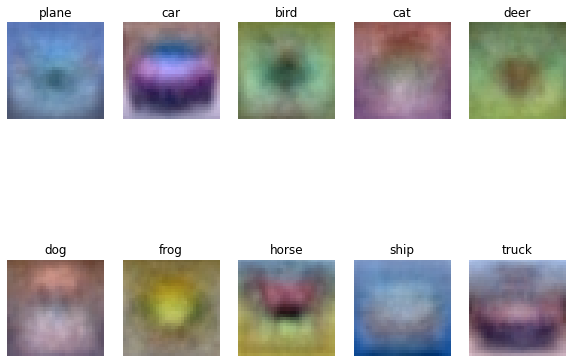

In [23]:
# 可视化每个类别的学习到的权重
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

---
# 重要

防止作业被吞

这里是作业的结尾处，请执行以下步骤:

1. 点击`File -> Save`或者用`control+s`组合键，确保你最新的的notebook的作业已经保存到谷歌云。
2. 执行以下代码确保 `.py` 文件保存回你的谷歌云。

In [24]:
# import os

# FOLDER_TO_SAVE = os.path.join('drive/My Drive/', FOLDERNAME)
# FILES_TO_SAVE = ['daseCV/classifiers/softmax.py']

# for files in FILES_TO_SAVE:
#   with open(os.path.join(FOLDER_TO_SAVE, '/'.join(files.split('/')[1:])), 'w') as f:
#     f.write(''.join(open(files).readlines()))